In [1]:
import sys,os

#sys.path.append('/home/arash/VRdataCleaning/DeepSurv/')

import importlib
import deepsurv
from statsmodels.stats.outliers_influence import variance_inflation_factor    
import argparse
import uuid
import pickle
import json
import time
import numpy as np
import pandas as pd

import lasagne
import optunity

import logging
from logging import handlers
from sklearn.model_selection import train_test_split

importlib.reload(deepsurv)

from deepsurv import deep_surv, utils, viz

from deepsurv.deepsurv_logger import DeepSurvLogger, TensorboardLogger
from eli5.permutation_importance import get_score_importances
import shap  # package used to calculate Shap values
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_pickle('ALLDATA.pkl')
data=data.loc[-data['Wait Time (s)'].isin(['Err1','Err2','Err3','Err4','Err5'])]
data=data.loc[data['Age_9-12'].isin([0,1])]


data=data.loc[:,['Wait Time (s)','Speed Limit', 'Lane Width', 'Minimum Gap', 'Mean Arrival Rate', 'AV', 
                   'Full Braking Before Impact_-1.0', 'Full Braking Before Impact_1', 
                   'Full Braking Before Impact_2', 'Full Braking Before Impact_3', 'Snowy',
                   'One way', 'two way', 'Two way with median', 'Night', 'numcars', 
                    'Age_9-12', 'Age_15-18', 'Age_12-15', 'Age_18 - 24', 'Age_25 - 29', 'Age_30 - 39', 'Age_50 - 59', 'Age_60+', 'Gender_Female', 'Occupation_Employed', 'Occupation_Student', 'Occupation_Unemployed', 
                   'Occupation_kid', 'Education_Bachelors degree', 'Education_College/University student', 
                   'Education_Doctorate degree', 'Education_High school diploma', 'Education_Masters degree', 
                   'Education_Professional degree', 'driving license_Yes', 'mode_Bike', 'mode_Car',
                   'mode_Public Transit', 'mode_Walking', 'workwalk_No', 'workwalk_Sometimes', 'workwalk_Yes', 
                   'shopwalk_No', 'shopwalk_Sometimes', 'shopwalk_Yes', 'Vrexp_Yes']]       #numwalk and VRexpnum removed because of some false inputs in the data should be fixed later

data=pd.get_dummies(data=data,columns=['Speed Limit','Lane Width','Minimum Gap','Mean Arrival Rate','numcars'])



data=data.apply(pd.to_numeric, errors='coerce')


def FullAV(row):
    if row['AV']==100:
        return 1
    else:
        return 0
def MixedAV(row):
    if row['AV']>0 and row['AV']<100:
        return 1
    else:
        return 0   
def HDV(row):
    if row['AV']==0:
        return 1

    else:
        return 0   
data=data[data.Occupation_kid==0]                         #remove kids


data['FullAV']=data.apply (lambda row: FullAV(row), axis=1)
data['Mixed']=data.apply (lambda row: MixedAV(row), axis=1)
#data['HDV']=data.apply (lambda row: HDV(row), axis=1)
data['over50']=data['Age_50 - 59']+data['Age_60+']
data=data.drop(columns=['Age_9-12', 'Age_15-18', 'Age_12-15','Occupation_kid','AV','Age_50 - 59','Age_60+'])
data['E']=1




data=data.drop(columns=['Full Braking Before Impact_3', 'two way', 'Occupation_Unemployed','Education_Doctorate degree','mode_Bike','workwalk_Yes','shopwalk_Yes','Speed Limit_50.0','Lane Width_3.0','Minimum Gap_2.0','Mean Arrival Rate_1100.0','numcars_4'])


train, test = train_test_split(data,test_size=0.2, random_state=1)       #20 percent of data is seperated for test set
NCtrain=train     #NC: Not changed, used later for shap, without a format change that deepsurv requires
NCtest= test
trainsub, valsub = train_test_split(train,test_size=0.2, random_state=1)   #20 percent of train data is set for validation set, for cross-validation train is used, for network training using opt_params, trainsub and valsub are used

In [3]:
def dataframe_to_deepsurv_ds(df, event_col = 'E', time_col = 'Wait Time (s)'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

def load_logger(logdir):
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG)
    format = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    
    # Print to Stdout
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(format)
    logger.addHandler(ch)

    # Print to Log file
    fh = logging.FileHandler(os.path.join(logdir, 'log_' + str(uuid.uuid4())))
    fh.setFormatter(format)
    logger.addHandler(fh)

    return logger

def load_box_constraints(file):
    with open(file, 'rb') as fp:
        return json.loads(fp.read())

def save_call_log(file, call_log):
    with open(file, 'wb') as fp:
        pickle.dump(call_log, fp)

def get_objective_function(num_epochs, logdir, update_fn = lasagne.updates.sgd):
    '''
    Returns the function for Optunity to optimize. The function returned by get_objective_function
    takes the parameters: x_train, y_train, x_test, and y_test, and any additional kwargs to 
    use as hyper-parameters.

    The objective function runs a DeepSurv model on the training data and evaluates it against the
    a validation set. The result of the function call is the validation concordance index 
    (which Optunity tries to optimize)
    '''
    def format_to_deepsurv(x, y):
        return {
            'x': x,
            'e': y[:,0].astype(np.int32),
            't': y[:,1].astype(np.float32)
        }

    def get_hyperparams(x,params):
        hyperparams = {
            'batch_norm': False,
            'activation': 'rectify',
            'standardize': True,
            'n_in':x.shape[1]
        }

        if 'num_layers' in params and 'num_nodes' in params:
            params['hidden_layers_sizes'] = [int(params['num_nodes'])] * int(params['num_layers'])
            del params['num_layers']
            del params['num_nodes']

        if 'learning_rate' in params:
            params['learning_rate'] = 10 ** params['learning_rate']
            
            

        hyperparams.update(params)
        return hyperparams

    def train_deepsurv(x_train,y_train,x_test,y_test,
        **kwargs):
        hyperparams = get_hyperparams(x_train,kwargs)
     
        
        # Standardize the datasets
        train_mean = x_train.mean(axis = 0)
        train_std = x_train.std(axis = 0)

        x_train = (x_train - train_mean) / train_std
        x_test = (x_test - train_mean) / train_std

        train_data = format_to_deepsurv(x_train, y_train)
        valid_data = format_to_deepsurv(x_test, y_test)

        

        # Set up Tensorboard loggers
        model_id = str(hash(str(hyperparams)))
        run_id = model_id + '_' + str(uuid.uuid4())
        logger = TensorboardLogger('hyperparam_search', 
            os.path.join(logdir,"tensor_logs", model_id, run_id))

        network = deep_surv.DeepSurv(**hyperparams)
        metrics = network.train(train_data, n_epochs = num_epochs, logger=logger, 
            update_fn = update_fn, verbose = False)

        result = network.get_concordance_index(**valid_data)
        main_logger.info('Run id: %s | %s | C-Index: %f | Train Loss %f' % (run_id, str(hyperparams), result, metrics['loss'][-1][1]))
        return result

    return train_deepsurv


## Find the optimal hyper-parameters using training data and save them in opt_params


In [4]:
NUM_EPOCHS = 500
NUM_FOLDS = 8
logdir='/home/arash/VRdataCleaning/logs'

train = dataframe_to_deepsurv_ds(train, event_col = 'E', time_col= 'Wait Time (s)')
xtrain = train['x']
etrain = train['e']
ttrain = train['t']
ytrain = np.column_stack((etrain, ttrain))
#    global main_logger

main_logger = load_logger(logdir)


#    main_logger.debug('Loading dataset: ' + args.dataset)
box_constraints = load_box_constraints('/home/arash/VRdataCleaning/box_constraints.0.json')

76
opt_fxn = get_objective_function(NUM_EPOCHS, logdir, 
                                 utils.get_optimizer_from_str('adam'))

opt_fxn = optunity.cross_validated(x=xtrain, y=ytrain, num_folds=NUM_FOLDS)(opt_fxn)

#    main_logger.debug('Maximizing C-Index. Num_iterations: %d' % args.num_evals)
opt_params, call_log, _ = optunity.maximize(opt_fxn, num_evals=20,
        solver_name='sobol',
        **box_constraints)



2019-05-27 16:44:48,751 - __main__ - INFO - Run id: -8770559188966815787_2cd40309-371a-45c4-8b00-770f83a68edc | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000732998046875, 'learning_rate': 2.142774959210328e-06, 'momentum': 0.81568701171875, 'L2_reg': 3.8410522460937497, 'dropout': 0.09055859375, 'hidden_layers_sizes': [96, 96, 96, 96]} | C-Index: 0.478233 | Train Loss 14.812817
2019-05-27 16:46:25,412 - __main__ - INFO - Run id: -8770559188966815787_c16b1893-7b66-458e-b294-7b314674aa00 | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000732998046875, 'learning_rate': 2.142774959210328e-06, 'momentum': 0.81568701171875, 'L2_reg': 3.8410522460937497, 'dropout': 0.09055859375, 'hidden_layers_sizes': [96, 96, 96, 96]} | C-Index: 0.493449 | Train Loss 14.369728
2019-05-27 16:48:01,189 - __main__ - INFO - Run id: -8770559188966815787_ebce1212-c16d-4f61-b001-6a8a968e670f | {'batch_norm': False, 

2019-05-27 17:16:09,787 - __main__ - INFO - Run id: 603115882958932329_b3fc1b6f-4a70-432f-bedd-a857ff1e4a49 | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000176123046875, 'learning_rate': 3.8768282592951703e-07, 'momentum': 0.89921826171875, 'L2_reg': 1.69708349609375, 'dropout': 0.31330859375000003, 'hidden_layers_sizes': [80, 80, 80, 80, 80]} | C-Index: 0.486025 | Train Loss 9.956464
2019-05-27 17:17:53,563 - __main__ - INFO - Run id: 603115882958932329_ca3a4a4f-d151-47f0-bcf2-4a90ea3a078c | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000176123046875, 'learning_rate': 3.8768282592951703e-07, 'momentum': 0.89921826171875, 'L2_reg': 1.69708349609375, 'dropout': 0.31330859375000003, 'hidden_layers_sizes': [80, 80, 80, 80, 80]} | C-Index: 0.492593 | Train Loss 9.447447
2019-05-27 17:19:35,919 - __main__ - INFO - Run id: 603115882958932329_f2df01b2-b27e-431d-8fc5-c554cfbd8180 | {'batch_norm

2019-05-27 17:40:55,534 - __main__ - INFO - Run id: -8952031022679119102_9c857b2c-1ae1-49b7-9a7d-703ce374bdda | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000918623046875, 'learning_rate': 3.7885808742365673e-06, 'momentum': 0.86209326171875, 'L2_reg': 0.4719584960937499, 'dropout': 0.016308593750000003, 'hidden_layers_sizes': [13, 13, 13, 13, 13, 13]} | C-Index: 0.480121 | Train Loss 7.470388
2019-05-27 17:42:19,050 - __main__ - INFO - Run id: -8952031022679119102_013c103e-05bd-49aa-9a0a-35a0ae686139 | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000918623046875, 'learning_rate': 3.7885808742365673e-06, 'momentum': 0.86209326171875, 'L2_reg': 0.4719584960937499, 'dropout': 0.016308593750000003, 'hidden_layers_sizes': [13, 13, 13, 13, 13, 13]} | C-Index: 0.542625 | Train Loss 7.485105
2019-05-27 17:43:31,288 - __main__ - INFO - Run id: -7163236675221937241_904af2f1-4a85-4e7b-b471-0ebf769

2019-05-27 18:05:54,725 - __main__ - INFO - Run id: -2835277279866782064_c36a1c1b-bcbc-486d-bd05-c9ecaa1d9ff2 | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.0007948730468750001, 'learning_rate': 0.00011573815701829784, 'momentum': 0.91778076171875, 'L2_reg': 1.0845209960937499, 'dropout': 0.16480859375, 'hidden_layers_sizes': [91, 91]} | C-Index: 0.643661 | Train Loss 7.285312
2019-05-27 18:07:05,342 - __main__ - INFO - Run id: -2835277279866782064_582295bd-c1df-472d-80e4-627679f339d6 | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.0007948730468750001, 'learning_rate': 0.00011573815701829784, 'momentum': 0.91778076171875, 'L2_reg': 1.0845209960937499, 'dropout': 0.16480859375, 'hidden_layers_sizes': [91, 91]} | C-Index: 0.619561 | Train Loss 7.492127
2019-05-27 18:08:11,510 - __main__ - INFO - Run id: -2835277279866782064_0efa8bce-e79c-4c6d-86e9-6afa89c936a6 | {'batch_norm': False, 'activat

2019-05-27 18:33:48,573 - __main__ - INFO - Run id: -3987005523264385406_74a7f38f-6b5f-4dad-83ae-51b55294b8ad | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 5.237304687500001e-05, 'learning_rate': 1.184340450163137e-05, 'momentum': 0.8064057617187501, 'L2_reg': 2.30964599609375, 'dropout': 0.26380859375, 'hidden_layers_sizes': [24, 24, 24, 24]} | C-Index: 0.513030 | Train Loss 10.107628
2019-05-27 18:35:03,397 - __main__ - INFO - Run id: -3987005523264385406_29827615-dd64-496f-944e-3319d25c481c | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 5.237304687500001e-05, 'learning_rate': 1.184340450163137e-05, 'momentum': 0.8064057617187501, 'L2_reg': 2.30964599609375, 'dropout': 0.26380859375, 'hidden_layers_sizes': [24, 24, 24, 24]} | C-Index: 0.528461 | Train Loss 10.927543
2019-05-27 18:36:19,135 - __main__ - INFO - Run id: -3987005523264385406_d2789505-a67f-4d2c-a5bc-7beda7d8e16b | {'batch_norm':

2019-05-27 19:01:28,909 - __main__ - INFO - Run id: 6325003426198709578_9ba61b50-5eaa-4dff-9d6d-8b6cb516f1a7 | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000531904296875, 'learning_rate': 0.0001334601358234644, 'momentum': 0.84121044921875, 'L2_reg': 0.5485288085937499, 'dropout': 0.23287109375, 'hidden_layers_sizes': [42, 42, 42]} | C-Index: 0.623039 | Train Loss 6.894244
2019-05-27 19:02:50,308 - __main__ - INFO - Run id: -6037732616091310626_20789a32-2ff3-4287-a153-0eec0a99448e | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000779404296875, 'learning_rate': 1.4300511201447528e-07, 'momentum': 0.80408544921875, 'L2_reg': 4.22390380859375, 'dropout': 0.33187109375, 'hidden_layers_sizes': [20, 20, 20, 20, 20]} | C-Index: 0.518094 | Train Loss 14.735537
2019-05-27 19:04:11,974 - __main__ - INFO - Run id: -6037732616091310626_104eec35-2da7-452c-aa8b-f2c80f4fbaeb | {'batch_norm': False, 'ac

2019-05-27 19:25:50,090 - __main__ - INFO - Run id: -2957655188075177813_92d9ff99-56ed-4411-8159-5c8174c11d64 | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000408154296875, 'learning_rate': 4.4704533006170034e-07, 'momentum': 0.8226479492187501, 'L2_reg': 2.38621630859375, 'dropout': 0.08437109375, 'hidden_layers_sizes': [53, 53, 53, 53, 53, 53, 53]} | C-Index: 0.543843 | Train Loss 11.378610
2019-05-27 19:27:30,520 - __main__ - INFO - Run id: -2957655188075177813_d3175912-7bfa-4902-ae97-f21cb5610be5 | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000408154296875, 'learning_rate': 4.4704533006170034e-07, 'momentum': 0.8226479492187501, 'L2_reg': 2.38621630859375, 'dropout': 0.08437109375, 'hidden_layers_sizes': [53, 53, 53, 53, 53, 53, 53]} | C-Index: 0.511526 | Train Loss 10.632632
2019-05-27 19:29:09,947 - __main__ - INFO - Run id: -2957655188075177813_90c9b3d4-2bd5-4f0e-a3b2-04792f681fd

2019-05-27 19:57:08,168 - __main__ - INFO - Run id: -3752057516053553068_a775674f-03d4-4d01-8377-430f2614486d | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000655654296875, 'learning_rate': 4.3686933599076936e-06, 'momentum': 0.93402294921875, 'L2_reg': 1.16109130859375, 'dropout': 0.38137109375, 'hidden_layers_sizes': [75, 75, 75, 75, 75]} | C-Index: 0.490838 | Train Loss 8.828850
2019-05-27 19:58:48,027 - __main__ - INFO - Run id: -3752057516053553068_1ec92092-3bf9-4ac7-a377-860bd95c8c12 | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000655654296875, 'learning_rate': 4.3686933599076936e-06, 'momentum': 0.93402294921875, 'L2_reg': 1.16109130859375, 'dropout': 0.38137109375, 'hidden_layers_sizes': [75, 75, 75, 75, 75]} | C-Index: 0.526906 | Train Loss 8.664426
2019-05-27 20:00:29,784 - __main__ - INFO - Run id: -3752057516053553068_120d0712-eb4a-4a21-9978-8c89d880d863 | {'batch_norm': Fal

2019-05-27 20:21:01,593 - __main__ - INFO - Run id: 3937201985013017453_7d0efa42-3e46-4879-b136-1caeda31912e | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000717529296875, 'learning_rate': 2.4146353952188084e-05, 'momentum': 0.9247416992187499, 'L2_reg': 0.8548100585937499, 'dropout': 0.20812109375, 'hidden_layers_sizes': [14, 14, 14, 14, 14, 14, 14]} | C-Index: 0.579683 | Train Loss 7.764825
2019-05-27 20:22:28,578 - __main__ - INFO - Run id: 3937201985013017453_0aee26c2-f6d0-4d81-a2d6-f8b782732c20 | {'batch_norm': False, 'activation': 'rectify', 'standardize': True, 'n_in': 42, 'lr_decay': 0.000717529296875, 'learning_rate': 2.4146353952188084e-05, 'momentum': 0.9247416992187499, 'L2_reg': 0.8548100585937499, 'dropout': 0.20812109375, 'hidden_layers_sizes': [14, 14, 14, 14, 14, 14, 14]} | C-Index: 0.529133 | Train Loss 8.361190
2019-05-27 20:23:54,876 - __main__ - INFO - Run id: 3937201985013017453_7b16e2b1-3e7c-4311-a283-3cfd6239a90f


## train a network based on opt_params on training data and save the model and weights (previous sections used cross-validation to find hyper-parameters, weights could not be saved)

In [5]:
NUM_EPOCHS=1000
hyperparams = {
    'batch_norm': False,
    'activation': 'rectify',
    'standardize': True,
    'n_in':xtrain.shape[1]
}

hyperparams.update(opt_params)

if 'num_layers' in hyperparams and 'num_nodes' in hyperparams:
    hyperparams['hidden_layers_sizes'] = [int(hyperparams['num_nodes'])] * int(hyperparams['num_layers'])
    del hyperparams['num_layers']
    del hyperparams['num_nodes']

if 'learning_rate' in hyperparams:
    hyperparams['learning_rate'] = 10 ** hyperparams['learning_rate']

def format_to_deepsurv(x, y):
    return {
        'x': x,
        'e': y[:,0].astype(np.int32),
        't': y[:,1].astype(np.float32)
    }
trainsub = dataframe_to_deepsurv_ds(trainsub, event_col = 'E', time_col= 'Wait Time (s)')
xtrainsub = trainsub['x']
etrainsub = trainsub['e']
ttrainsub = trainsub['t']
ytrainsub = np.column_stack((etrainsub, ttrainsub))

valsub = dataframe_to_deepsurv_ds(valsub, event_col = 'E', time_col= 'Wait Time (s)')
xvalsub = valsub['x']
evalsub = valsub['e']
tvalsub = valsub['t']
yvalsub = np.column_stack((evalsub, tvalsub))



trainsub_mean = xtrainsub.mean(axis = 0)
trainsub_std = xtrainsub.std(axis = 0)
xtrainsub = (xtrainsub - trainsub_mean) / trainsub_std

trainsub_data=format_to_deepsurv(xtrainsub, ytrainsub)

valsub_mean = xvalsub.mean(axis = 0)
valsub_std = xvalsub.std(axis = 0)
xvalsub = (xvalsub - valsub_mean) / valsub_std

valsub_data=format_to_deepsurv(xvalsub, yvalsub)


network = deep_surv.DeepSurv(**hyperparams)
metrics = network.train(trainsub_data,valsub_data, n_epochs = NUM_EPOCHS, update_fn = lasagne.updates.sgd, verbose = True)

## apply the trained network on test set and check the feature importance for generalization using  [permutation importance](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)


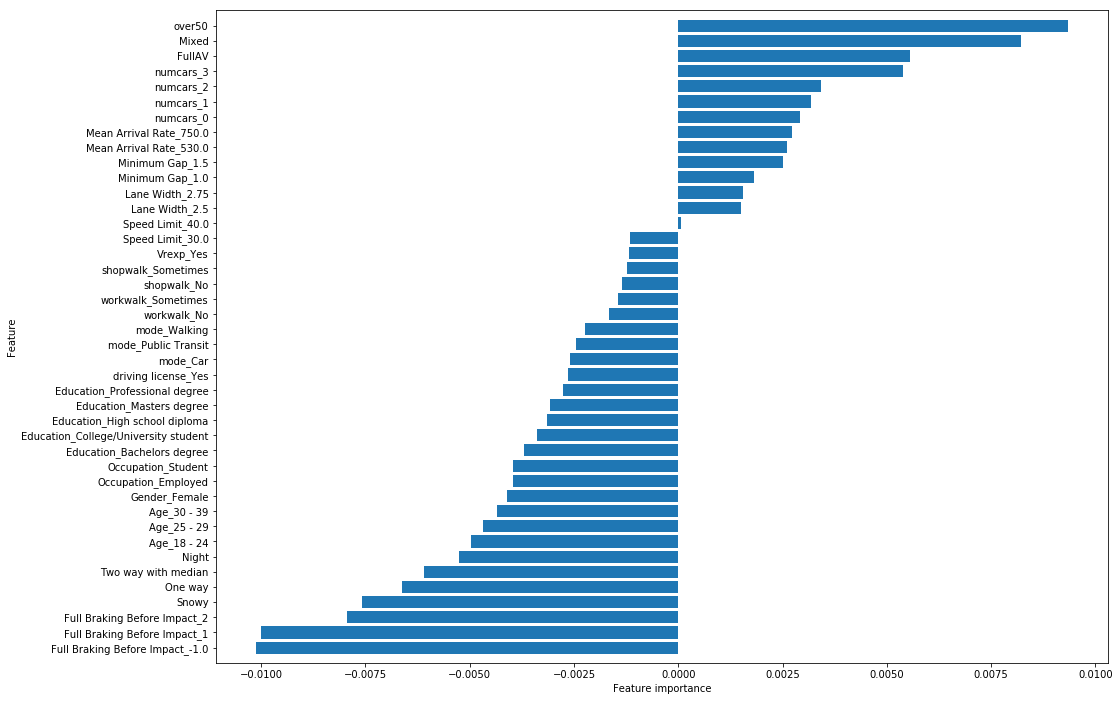

In [6]:
colnames=test.iloc[:,1:-1].columns
def score(X, y):
    X=pd.DataFrame(X)
    X.columns=colnames
    data=X
    data['Wait Time (s)']=y.values
    data['E']=1
    test = dataframe_to_deepsurv_ds(data, event_col = 'E', time_col= 'Wait Time (s)')
    xtest=test['x']
    xtest = (xtest - trainsub_mean) / trainsub_std              
    etest=test['e']
    ttest=test['t']
    ytest = np.column_stack((etest, ttest))
    valid_data = format_to_deepsurv(xtest, ytest)               #fix: networl is trained again on test data
    ci=network.get_concordance_index(**valid_data)
    return ci


st=time.time()

base_score, score_decreases = get_score_importances(score, test.iloc[:,1:-1].values, test.iloc[:,0])
                                                    #,columns_to_shuffle=range(0,2))
f=time.time()

feature_importances_mean = np.mean(score_decreases, axis=0)
feature_importances_std = np.std(score_decreases, axis=0)

perimportance=pd.DataFrame(data=feature_importances_mean,index=colnames,columns=['mean'])
perimportance['std']=feature_importances_std



perimportance=perimportance.sort_values(by=['mean'])



def plot_feature_importances(imp):
    plt.figure(figsize=(16,12))
    n_features = imp.shape[0]
    plt.barh(range(n_features), perimportance.iloc[:,0].values, align='center')
    plt.yticks(np.arange(n_features), colnames)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(perimportance)
#plt.savefig('Decision Tree feature_importance')

## Using Shap for feature importance

Using 1832 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


  0%|          | 0/459 [00:00<?, ?it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  0%|          | 1/459 [00:14<1:50:18, 14.45s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  0%|          | 2/459 [00:28<1:49:56, 14.44s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.

  5%|▍         | 21/459 [05:03<1:45:24, 14.44s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  5%|▍         | 22/459 [05:18<1:45:18, 14.46s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  5%|▌         | 23/459 [05:32<1:45:29, 14.52s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

  9%|▉         | 42/459 [10:07<1:40:03, 14.40s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  9%|▉         | 43/459 [10:22<1:40:06, 14.44s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 10%|▉         | 44/459 [10:36<1:40:15, 14.50s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 14%|█▎        | 63/459 [15:12<1:35:54, 14.53s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 14%|█▍        | 64/459 [15:26<1:35:43, 14.54s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 14%|█▍        | 65/459 [15:41<1:35:13, 14.50s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 18%|█▊        | 84/459 [20:16<1:30:46, 14.53s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 19%|█▊        | 85/459 [20:30<1:30:35, 14.53s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 19%|█▊        | 86/459 [20:45<1:30:04, 14.49s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 23%|██▎       | 105/459 [25:19<1:25:09, 14.43s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 23%|██▎       | 106/459 [25:34<1:24:51, 14.42s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 23%|██▎       | 107/459 [25:48<1:24:30, 14.41s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 27%|██▋       | 126/459 [30:23<1:20:07, 14.44s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 28%|██▊       | 127/459 [30:37<1:19:58, 14.45s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 28%|██▊       | 128/459 [30:51<1:19:43, 14.45s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 32%|███▏      | 147/459 [35:27<1:15:29, 14.52s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 32%|███▏      | 148/459 [35:41<1:14:57, 14.46s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 32%|███▏      | 149/459 [35:55<1:14:39, 14.45s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 37%|███▋      | 168/459 [40:31<1:10:16, 14.49s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 37%|███▋      | 169/459 [40:45<1:10:01, 14.49s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 37%|███▋      | 170/459 [41:00<1:09:49, 14.49s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 41%|████      | 189/459 [45:35<1:05:07, 14.47s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 41%|████▏     | 190/459 [45:50<1:05:00, 14.50s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 42%|████▏     | 191/459 [46:04<1:04:41, 14.48s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 46%|████▌     | 210/459 [50:39<1:00:00, 14.46s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 46%|████▌     | 211/459 [50:54<59:45, 14.46s/it]  /home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 46%|████▌     | 212/459 [51:08<59:25, 14.43s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the nex

 50%|█████     | 231/459 [55:43<55:11, 14.52s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 51%|█████     | 232/459 [55:57<54:56, 14.52s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 51%|█████     | 233/459 [56:12<54:34, 14.49s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next ve

 55%|█████▍    | 252/459 [1:00:47<49:58, 14.48s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 55%|█████▌    | 253/459 [1:01:02<49:51, 14.52s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 55%|█████▌    | 254/459 [1:01:16<49:28, 14.48s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 59%|█████▉    | 273/459 [1:05:52<45:04, 14.54s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 60%|█████▉    | 274/459 [1:06:07<44:52, 14.56s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 60%|█████▉    | 275/459 [1:06:21<44:30, 14.52s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 64%|██████▍   | 294/459 [1:10:56<39:53, 14.51s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 64%|██████▍   | 295/459 [1:11:11<39:39, 14.51s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 64%|██████▍   | 296/459 [1:11:25<39:20, 14.48s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 69%|██████▊   | 315/459 [1:16:00<34:44, 14.47s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 69%|██████▉   | 316/459 [1:16:15<34:35, 14.52s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 69%|██████▉   | 317/459 [1:16:30<34:22, 14.52s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 73%|███████▎  | 336/459 [1:21:05<29:47, 14.54s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 73%|███████▎  | 337/459 [1:21:20<29:31, 14.52s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 74%|███████▎  | 338/459 [1:21:34<29:14, 14.50s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 78%|███████▊  | 357/459 [1:26:10<24:37, 14.49s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 78%|███████▊  | 358/459 [1:26:24<24:23, 14.49s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 78%|███████▊  | 359/459 [1:26:39<24:08, 14.48s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 82%|████████▏ | 378/459 [1:31:14<19:33, 14.49s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 83%|████████▎ | 379/459 [1:31:29<19:19, 14.49s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 83%|████████▎ | 380/459 [1:31:43<19:07, 14.53s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 87%|████████▋ | 399/459 [1:36:19<14:29, 14.49s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 87%|████████▋ | 400/459 [1:36:33<14:13, 14.47s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 87%|████████▋ | 401/459 [1:36:48<13:59, 14.47s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 92%|█████████▏| 420/459 [1:41:23<09:25, 14.50s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 92%|█████████▏| 421/459 [1:41:37<09:12, 14.53s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 92%|█████████▏| 422/459 [1:41:52<08:56, 14.51s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 96%|█████████▌| 441/459 [1:46:27<04:20, 14.49s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 96%|█████████▋| 442/459 [1:46:42<04:06, 14.48s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 97%|█████████▋| 443/459 [1:46:56<03:51, 14.46s/it]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

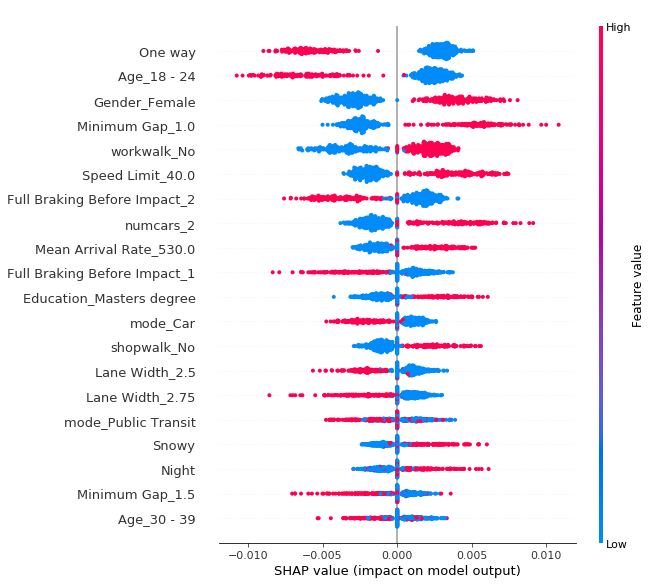

In [7]:
explainer = shap.KernelExplainer(network.predict_risk,NCtrain.iloc[:,1:-1])

#shap_values = explainer.shap_values(NCtest.iloc[2,1:-1])
shap.initjs()
#shap.force_plot(explainer.expected_value[0], shap_values[0], NCtest.iloc[2,1:-1])

shap_values = explainer.shap_values(NCtest.iloc[:,1:-1])

shap.summary_plot(shap_values[0], NCtest.iloc[:,1:-1])

In [8]:

plt.savefig('Decision Tree feature_importance')
#plt.savefig('Decision Tree feature_importance')



<Figure size 432x288 with 0 Axes>

In [9]:
shap_values = explainer.shap_values(NCtest.iloc[2,1:-1])
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], NCtest.iloc[2,1:-1])

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
